## **What Neighborhood should I live in? - A recommendation system for new Expats** 
#### Using K-means Clustering and Content based recommendation to select suitable neighborhoods in a new city basis user preferences 

Where to live in a new city is one of the most daunting tasks and depends at a big part a matter of one's preferences and lifestyle. This project tries to create a content based recommendation system for assisting expats in choosing a neighborhood basis the way they rank a number of lifestyle categories. For testing this method we will use Toronto/Canada as an example city. 

Toronto is a multiculturalcity that continues to attract a big number of expats from different countries in the world. Its neighbourhoods are constantly evolving, and boundaries can become blurred and disputed, so the pure geographically defined Neighborhoods are not the best benchmark for suitability to a new expat that doesnt know the city and help him choose where to live.



### **Data source**

For the purpose of this project we will be using date from two sources: We will scrap the Neighborhood/area data for Toronto from Wikipedia to create a list of Neighborhoods with geographical coordinates and then using the Foursquare API we will explore the venues listed in Toronto, which will help us create the lifestyle categories we need. 
Links to the data:
List of Neighborhoods organized by Postal Codes:

- https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
- List of Coordinates:
  http://cocl.us/Geospatial_data

For the venue categories:
Foursquare API - https://developer.foursquare.com/docs/api/venues/explore


For scrapping the data from Wikipedia **BeautifulSoup** package is used. BeautifulSoup is a Python library for pulling data out of HTML and XML files 

**Accordingly the BeautifulSoup libraries were imported:**

In [1]:
from bs4 import BeautifulSoup
import requests
print("import complete")

import complete


And we imported rest libraries used for our further data processing and visualizations:

In [2]:
                                                       

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json 

!pip install geopy
from geopy.geocoders import Nominatim 
!pip install geocoder

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install folium
import folium

print('Libraries imported.')

    100% |████████████████████████████████| 102kB 18.4MB/s 
Libraries imported.


 BeautifulSoup was used to get the data create a pandas dataframe

In [3]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]

type(df)

pandas.core.frame.DataFrame

Column names were assigned:

In [4]:
df.columns=['Postcode','Borough','Neighborhood']

First line was dropped as its not part of the data we need:

In [5]:
df.drop(df.index[0],inplace=True)

 "Not assigned" parameters of Neighborhood column were replaced with the value of their Borough:

In [6]:
df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned', df['Borough'], df['Neighborhood'])


A new dataframe was created exluding all rows that have "Not assigned" Borough

In [7]:
df_new=df[df.Borough !='Not assigned']

Where  Neighborhoods shared the same Postal codes, the rows were merged and Neighborhoods names were seperated with a comma and assigned  under the dataframe df_t:

In [8]:
df_t=df_new.groupby(['Postcode','Borough'])['Neighborhood'].apply(','.join)
df_t= df_t.to_frame().reset_index()
df_t.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
df_t.shape

(103, 3)

Next the coordinates were imported:

In [10]:
df_data_1 = pd.read_csv('http://cocl.us/Geospatial_data')
df_data_1.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


"Postal Code" column was renamed and df_data_1 was merged with Neighborhoods dataframe df_t

In [11]:
df_data_1.columns = df_data_1.columns.str.replace('Postal Code','Postcode')

In [12]:
df_data_1.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
df_toronto=pd.merge(df_t, df_data_1, on="Postcode")
df_toronto.shape

(103, 5)

In [14]:
df_toronto.dropna()
df_toronto.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Toronto coordinates were used to set the center location:

In [15]:
address = 'Toronto, TO'

geolocator = Nominatim(user_agent="TO_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6524203, -79.3834045.


The Neighborhoods were mapped using folium library basis their coordinates:

In [16]:
map_toronto_neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood']):
    label = '{}'.format(label)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_neighborhoods)  
    
map_toronto_neighborhoods

**Foursquare has numerous ‘Venue Categories’ that are used to identify each type of venue. A ‘GET’ request is sent to the ‘api.foursquare.com/v2/venues/explore?’ endpoint and results are appended to a list that is used to start the segmentation and explore Toronto Neigbhorhoods and venues**


In [17]:
CLIENT_ID = 'TZV5X5URLJIWHPZR01A3OTBXRZIUUL2UILGAZXSWFKYXCLD0' 
CLIENT_SECRET = 'J1Y5FJCYQHKFVH2GU5T0YYASWESE10XNOBRSNC13P2AWR2K4' 
VERSION = '20190326' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TZV5X5URLJIWHPZR01A3OTBXRZIUUL2UILGAZXSWFKYXCLD0
CLIENT_SECRET:J1Y5FJCYQHKFVH2GU5T0YYASWESE10XNOBRSNC13P2AWR2K4


**Explore Toronto Neighborhoods** <br>

The following function recursively sends a ‘get’ request to Foursquare for each neighborhood that requests all related venues. While looping through each neighborhood from the Toronto dataset, the function appends each venue entry to a list and, after looping through each neighborhood, creates a DataFrame of all of the results. Included for each entry in the dataset are neighborhood name and location, Venue category,name and location.

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
      
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The function is run for all Neighborhoods in Toronto and a new dataframe called Toronto_venues is created:

In [19]:
Toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                 )


Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

Number of venues  created for each Neighborhood:

In [20]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",2,2,2,2,2,2
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",12,12,12,12,12,12
"Alderwood,Long Branch",10,10,10,10,10,10
"Bathurst Manor,Downsview North,Wilson Heights",18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4
"Bedford Park,Lawrence Manor East",24,24,24,24,24,24
Berczy Park,55,55,55,55,55,55


Number of unique categories found from the generated data:

In [21]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 275 uniques categories.


### **Detecting Outliers**
A filter for outliers is needed before proceeding with further processing as extreme values will affect the results for both clustering and recommendation

A quick look at the number of occurences:

In [22]:
idx=Toronto_venues.groupby([ 'Venue Category']).size()
sortidx=idx.sort_values(ascending=False)
sortidx.head()

Venue Category
Coffee Shop    188
Café            99
Restaurant      60
Pizza Place     55
Bakery          53
dtype: int64

On a first look "Coffee Shop" and "Café" are the obvious outliers. To verify this visual conclusion, **Z score** with a threshold=3 is used to identify outliers using **SciPy** library. 

Z score is a measure of how many standard deviations below or above the population mean a raw score is. Z-scores range from -3 standard deviations (which would fall to the far left of the normal distribution curve) up to +3 standard deviations (which would fall to the far right of the normal distribution curve). 

In [23]:
sort=idx.to_frame().reset_index()
ix=sort.rename(columns={ sort.columns[1]: 'count' })


In [24]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(ix['count']))
print(z)

[3.25394840e-01 4.51516871e-01 4.51516871e-01 3.88455855e-01
 4.51516871e-01 4.51516871e-01 3.88455855e-01 3.88455855e-01
 3.88455855e-01 1.37725258e+00 3.25394840e-01 1.99272809e-01
 4.51516871e-01 1.79093284e-01 3.88455855e-01 1.36211793e-01
 3.05215315e-01 1.99272809e-01 4.51516871e-01 4.51516871e-01
 1.99272809e-01 4.51516871e-01 1.99272809e-01 2.82765593e+00
 6.83581408e-01 2.32316781e+00 1.99272809e-01 3.88455855e-01
 3.88455855e-01 2.62333824e-01 4.51516871e-01 4.31337346e-01
 5.29712530e-02 3.25394840e-01 3.88455855e-01 2.62333824e-01
 4.51516871e-01 4.94398361e-01 1.99272809e-01 3.88455855e-01
 1.12500852e+00 3.05215315e-01 4.51516871e-01 1.79093284e-01
 3.25394840e-01 1.44031359e+00 3.68276330e-01 1.99272809e-01
 2.62333824e-01 3.88455855e-01 4.51516871e-01 3.88455855e-01
 4.51516871e-01 5.72846264e+00 4.51516871e-01 4.51516871e-01
 4.51516871e-01 1.79093284e-01 4.51516871e-01 1.00897625e-02
 8.72764454e-01 4.51516871e-01 3.88455855e-01 4.51516871e-01
 1.44031359e+00 4.313373

In [25]:
threshold = 3
print(np.where(z > 3))

(array([ 53,  66, 219]),)


In [59]:
ix.iloc[[66,53,219],[0,1]]

,Venue Category,count
66,Coffee Shop,188
53,Café,99
219,Restaurant,60


In [27]:
print(z[53],z[66],z[219])

5.728462643903424 11.340893019370231 3.2690830411707785


From Z score method we see that 3 observations were above the threshold - "Coffee Shop" and "Café" followed by a lower score of "Restaurants". For our further feature selection we will intentionally keep "Restaurants" as a category but will limit it through aggregation of selected features.

**Neighborhood venues analysis**

Onehot coding is used to create a dataframe with occurence of each venue present (1) or not (0) under each Neighborhood

In [28]:

Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']],prefix="",prefix_sep="")

Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 


fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The rows are grouped by neighborhood and the mean of the frequency of occurrence of each category is calculated:

In [29]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()


,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0
1,Agincourt,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,"Alderwood,Long Branch",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0


"Neighborhood" is set as index:

In [30]:
Toronto_grouped.set_index('Neighborhood', inplace=True)


In [31]:
Toronto_grouped.head(3)

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide,King,Richmond",0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0
Agincourt,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0


### **Feature Selection**

Currently there are 274 venue categories in the dataset with a lot of them belonging to the same general "group". i.e there is "Vietnamese Restaurant", "Greek Restaurant", "Vegetarian Restaurant" all belonging to the same logical group. The 274 venues will be filtered through a key words search so to create a number of higher level categories which will be used for both clustering as well as recommendation. 

For this purpose the categories created with corresponding filters are:

1. Restaurants - keywords *(Restaurant|Steak|Bistro)*
2. Fast_Food - keywords *(Fast|Burger|Food Truck|Sandwich|Pizza Place|Place|Joint)*
3. Health_Fitness - keywords *(Yoga|Gym|Martial|Health|Fitness|Pool|Healthy|Field|Sports|Trail|Stadium|Tennis|Climbing)*
4. Kids_Friendly - keywords *(Kid|Play|Park|Nursery|Playground|School|College|Nursery|Medical Center|Clinic|Basketball|Football)*
5. Nightlife' - keywords *(Night|Bar|Pub|Wine|Dance|Strip Club|Adult|Club|Speakeasy|Liquor|Brewery)*
6. Culture - keywords *(Gallery|Museum|Paintings|Monument|Church|Theater|Cinema|Sculpture|Aquarium|Concert|Art)*
7. Shopping - keywords *(Mall|Shopping|Shop|Retail|Store|Boutique)*
8. Short_stay - keywords *(Motel|Hotel|Airport|Stay)*
9. Personal_care - keywords *(Salon|Barber|Spa|Massage|Hair|Nail|Tanning)*
10. Food_markets - keywords *(Supermarket|Market|Grocery|Bakery|Butcher)*
11. Transportation - keywords *(Train|Metro|Bus|Tram|Boat)*
12. Leisure - keywords *(Beach|Plaza|Skating)*

In [60]:
pd.options.mode.chained_assignment = None

Toronto_1=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Restaurant|Steak|Bistro')]
Toronto_1['total1']=Toronto_1.sum(axis=1)

Toronto_2=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Fast|Burger|Food Truck|Sandwich|Pizza Place|Place|Joint')]
Toronto_2['total2']=Toronto_2.sum(axis=1)

Toronto_3=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Yoga|Gym|Martial|Health|Fitness|Pool|Healthy|Field|Sports|Trail|Stadium|Tennis|Climbing')]
Toronto_3['total3']=Toronto_3.sum(axis=1)

Toronto_4=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Kid|Play|Park|Nursery|Playground|School|College|Nursery|Medical Center|Clinic|Basketball|Football')]
Toronto_4['total4']=Toronto_4.sum(axis=1)

Toronto_5=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Night|Bar|Pub|Wine|Dance|Strip Club|Adult|Club|Speakeasy|Liquor|Brewery')]
Toronto_5['total5']=Toronto_5.sum(axis=1)

Toronto_6=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Gallery|Museum|Paintings|Monument|Church|Theater|Cinema|Sculpture|Aquarium|Concert|Art')]
Toronto_6['total6']=Toronto_6.sum(axis=1)

Toronto_7=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Mall|Shopping|Shop|Retail|Store|Boutique')]
Toronto_7['total7']=Toronto_7.sum(axis=1)

Toronto_8=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Motel|Hotel|Airport|Stay')]
Toronto_8['total8']=Toronto_8.sum(axis=1)

Toronto_9=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Salon|Barber|Spa|Massage|Hair|Nail|Tanning')]
Toronto_9['total9']=Toronto_9.sum(axis=1)

Toronto_10=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Supermarket|Market|Grocery|Bakery|Butcher')]
Toronto_10['total10']=Toronto_10.sum(axis=1)

Toronto_11=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Train|Metro|Bus|Tram|Boat')]
Toronto_11['total11']=Toronto_11.sum(axis=1)

Toronto_12=Toronto_grouped.loc[:, Toronto_grouped.columns.str.contains('Beach|Plaza|Skating')]
Toronto_12['total12']=Toronto_12.sum(axis=1)



,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Health_Fitness,Kids_Friendly,Nightlife,Culture,Shopping,Short_stay,Personal_care,Food_markets,Transportation,Leisure
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide,King,Richmond",0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.06,0.0,0.200000,0.06,0.3,0.03,0.01,0.030000,0.0,0.01
Agincourt,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.000000,0.00,0.5,0.00,0.00,0.000000,0.0,0.00
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,2.0,0.000000,0.00,0.0,0.00,0.00,0.000000,0.0,0.00
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.166667,0.00,1.0,0.00,0.00,0.166667,0.0,0.00
"Alderwood,Long Branch",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.40,0.0,0.400000,0.00,0.2,0.00,0.00,0.000000,0.0,0.10


In [33]:
Toronto_grouped['Restaurants']=Toronto_1['total1']
Toronto_grouped['Fast_Food']=Toronto_2['total2']
Toronto_grouped['Health_Fitness']=Toronto_3['total3']
Toronto_grouped['Kids_Friendly']=Toronto_4['total4']
Toronto_grouped['Nightlife']=Toronto_5['total5']
Toronto_grouped['Culture']=Toronto_6['total6']
Toronto_grouped['Shopping']=Toronto_7['total7']
Toronto_grouped['Short_stay']=Toronto_8['total8']
Toronto_grouped['Personal_care']=Toronto_9['total9']
Toronto_grouped['Food_markets']=Toronto_10['total10']
Toronto_grouped['Transportation']=Toronto_11['total11']
Toronto_grouped['Leisure']=Toronto_12['total12']
Toronto_grouped.head(5)

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Health_Fitness,Kids_Friendly,Nightlife,Culture,Shopping,Short_stay,Personal_care,Food_markets,Transportation,Leisure
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide,King,Richmond",0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.03,0.0,0.100000,0.06,0.15,0.03,0.01,0.030000,0.0,0.01
Agincourt,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.000000,0.00,0.25,0.00,0.00,0.000000,0.0,0.00
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.0,0.000000,0.00,0.00,0.00,0.00,0.000000,0.0,0.00
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.083333,0.00,0.50,0.00,0.00,0.166667,0.0,0.00
"Alderwood,Long Branch",0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.20,0.0,0.200000,0.00,0.10,0.00,0.00,0.000000,0.0,0.10


In [34]:
Toronto_grouped_new= Toronto_grouped[['Restaurants',
                                    'Fast_Food',
                                    'Health_Fitness',
                                    'Kids_Friendly',
                                    'Nightlife',
                                    'Culture',
                                    'Shopping',
                                    'Short_stay',
                                    'Personal_care',
                                    'Food_markets',
                                    'Transportation',
                                    'Leisure']].copy()
Toronto_grouped_new.head()

,Restaurants,Fast_Food,Health_Fitness,Kids_Friendly,Nightlife,Culture,Shopping,Short_stay,Personal_care,Food_markets,Transportation,Leisure
Neighborhood,,,,,,,,,,,,
"Adelaide,King,Richmond",0.320000,0.090000,0.03,0.0,0.100000,0.06,0.15,0.03,0.01,0.030000,0.0,0.01
Agincourt,0.000000,0.250000,0.00,0.0,0.000000,0.00,0.25,0.00,0.00,0.000000,0.0,0.00
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",0.000000,0.000000,0.00,1.0,0.000000,0.00,0.00,0.00,0.00,0.000000,0.0,0.00
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",0.166667,0.333333,0.00,0.0,0.083333,0.00,0.50,0.00,0.00,0.166667,0.0,0.00
"Alderwood,Long Branch",0.000000,0.300000,0.20,0.0,0.200000,0.00,0.10,0.00,0.00,0.000000,0.0,0.10


In [35]:
Toronto_grouped_new.shape

(100, 12)

#### Let's print each neighborhood along with the top 5 most common venues

First the Neighborhood is returned as a column in the dataframe

In [36]:
Toronto_grouped_new.reset_index(level=0,inplace=True)

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 5

indicators = ['st', 'nd', 'rd']


columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped_new['Neighborhood']

for ind in np.arange(Toronto_grouped_new.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped_new.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,King,Richmond",Restaurants,Shopping,Nightlife,Fast_Food,Culture
1,Agincourt,Shopping,Fast_Food,Leisure,Transportation,Food_markets
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Kids_Friendly,Leisure,Transportation,Food_markets,Personal_care
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Shopping,Fast_Food,Food_markets,Restaurants,Nightlife
4,"Alderwood,Long Branch",Fast_Food,Nightlife,Health_Fitness,Leisure,Shopping
5,"Bathurst Manor,Downsview North,Wilson Heights",Shopping,Fast_Food,Restaurants,Food_markets,Leisure
6,Bayview Village,Restaurants,Leisure,Transportation,Food_markets,Personal_care
7,"Bedford Park,Lawrence Manor East",Restaurants,Shopping,Fast_Food,Nightlife,Food_markets
8,Berczy Park,Restaurants,Shopping,Nightlife,Food_markets,Culture
9,"Birch Cliff,Cliffside West",Leisure,Kids_Friendly,Health_Fitness,Transportation,Food_markets


In [38]:
 neighborhoods_venues_sorted.to_csv("Recommender visualization/top5.csv", index=False)


### **K-means Clustering**

In [39]:
from sklearn.preprocessing import StandardScaler
X = Toronto_grouped_new.values[:,1:].astype(float)
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.81010254, -0.17712967, -0.35258293, ..., -0.21202455,
        -0.30773218,  0.08072822],
       [-1.02195508,  0.88648141, -0.56617468, ..., -0.57977124,
        -0.30773218, -0.19456288],
       [-1.02195508, -0.7754109 , -0.56617468, ..., -0.57977124,
        -0.30773218, -0.19456288],
       ...,
       [-0.14115815,  1.26999502,  1.07683881, ..., -0.57977124,
        -0.30773218, -0.19456288],
       [-1.02195508, -0.7754109 , -0.56617468, ..., -0.57977124,
        -0.30773218,  6.68771461],
       [-1.02195508, -0.7754109 , -0.56617468, ..., -0.57977124,
        -0.30773218, -0.19456288]])

In [40]:
cluster_dataset.shape

(100, 12)

#compare dataframes
df = pd.concat([Toronto_grouped_new, cluster_dataset]) # concat dataframes
df = df.reset_index(drop=True) # reset the index
df_gpby = df.groupby(list(df.columns)) #group by
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1] #reindex
 

In [79]:
from sklearn.cluster import KMeans
num_clusters = 5
k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[0 0 2 0 1 0 0 0 0 1 0 0 0 4 2 0 0 0 0 0 0 0 0 4 0 0 2 0 0 0 0 0 0 1 0 0 4
 1 0 2 0 2 1 0 0 0 1 0 0 0 0 0 0 3 1 0 1 0 1 4 0 0 0 4 0 0 0 1 0 2 0 0 4 0
 2 2 0 0 0 2 3 0 0 0 0 0 0 0 4 2 0 0 0 2 0 0 0 0 1 2]


In [80]:
Toronto_grouped_new["Labels"] = labels
Toronto_grouped_new.head()

,Restaurants,Fast_Food,Health_Fitness,Kids_Friendly,Nightlife,Culture,Shopping,Short_stay,Personal_care,Food_markets,Transportation,Leisure,Labels
Neighborhood,,,,,,,,,,,,,
"Adelaide,King,Richmond",0.320000,0.090000,0.03,0.0,0.100000,0.06,0.15,0.03,0.01,0.030000,0.0,0.01,0
Agincourt,0.000000,0.250000,0.00,0.0,0.000000,0.00,0.25,0.00,0.00,0.000000,0.0,0.00,0
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",0.000000,0.000000,0.00,1.0,0.000000,0.00,0.00,0.00,0.00,0.000000,0.0,0.00,2
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",0.166667,0.333333,0.00,0.0,0.083333,0.00,0.50,0.00,0.00,0.166667,0.0,0.00,0
"Alderwood,Long Branch",0.000000,0.300000,0.20,0.0,0.200000,0.00,0.10,0.00,0.00,0.000000,0.0,0.10,1


Toronto_grouped_new.groupby('Labels').mean()

In [81]:
toronto_merged = Toronto_grouped_new
toronto_merged = toronto_merged.join(df_toronto.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() 

,Restaurants,Fast_Food,Health_Fitness,Kids_Friendly,Nightlife,Culture,Shopping,Short_stay,Personal_care,Food_markets,Transportation,Leisure,Labels,Postcode,Borough,Latitude,Longitude
Neighborhood,,,,,,,,,,,,,,,,,
"Adelaide,King,Richmond",0.320000,0.090000,0.03,0.0,0.100000,0.06,0.15,0.03,0.01,0.030000,0.0,0.01,0,M5H,Downtown Toronto,43.650571,-79.384568
Agincourt,0.000000,0.250000,0.00,0.0,0.000000,0.00,0.25,0.00,0.00,0.000000,0.0,0.00,0,M1S,Scarborough,43.794200,-79.262029
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",0.000000,0.000000,0.00,1.0,0.000000,0.00,0.00,0.00,0.00,0.000000,0.0,0.00,2,M1V,Scarborough,43.815252,-79.284577
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",0.166667,0.333333,0.00,0.0,0.083333,0.00,0.50,0.00,0.00,0.166667,0.0,0.00,0,M9V,Etobicoke,43.739416,-79.588437
"Alderwood,Long Branch",0.000000,0.300000,0.20,0.0,0.200000,0.00,0.10,0.00,0.00,0.000000,0.0,0.10,1,M8W,Etobicoke,43.602414,-79.543484


In [83]:
toronto_merged.reset_index(level=0, inplace=True)


In [74]:
 toronto_merged.to_csv("Recommender visualization/clusters.csv", index=False)


In [70]:

Sum_of_squared_distances = []
K = range(1,12)
for k in K:
    km = KMeans(n_clusters=k,n_init=12)
    km = km.fit(cluster_dataset)
    Sum_of_squared_distances.append(km.inertia_)

    

In [71]:
print(Sum_of_squared_distances)

[1199.9999999999998, 1073.2792639205777, 969.3363397335875, 869.0197276691788, 781.9352852325773, 698.8072881273478, 635.0252494931665, 556.9442101496218, 479.4342806638439, 423.30523338290504, 394.8044367664378]


6


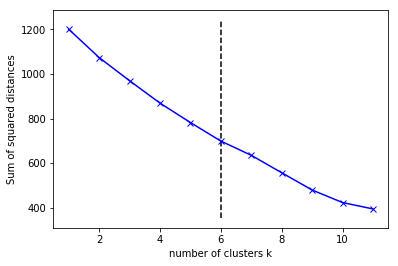

In [72]:
y=Sum_of_squared_distances

x = range(1, len(y)+1)

from kneed import KneeLocator
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print(kn.knee)
plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.plot(x, y, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


In [84]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

##### Now, we feed the system with user ratings for each of the 12 categories we created depending on how important each was for the user in a scale of 1-10. For the testing purpose we used a “persona” of a user that is married with children and rated each category accordingly. 

In [85]:
userInput_Family = [
            {'Venue':'Restaurants','Rating':7},
            {'Venue':'Fast_Food','Rating':5},
            {'Venue':'Health_Fitness','Rating':2},
            {'Venue':'Kids_Friendly','Rating':10},
            {'Venue':'Nightlife','Rating':1},
            {'Venue':'Culture','Rating':8},
            {'Venue':'Shopping','Rating':6},
            {'Venue':'Short_stay','Rating':0},
            {'Venue':'Personal_care','Rating':6},
            {'Venue':'Food_markets','Rating':10},
            {'Venue':'Transportation','Rating':5},
            {'Venue':'Leisure','Rating':8}
         ] 
inputVenues_Family = pd.DataFrame(userInput_Family) 

inputVenues_Family

,Rating,Venue
0,7,Restaurants
1,5,Fast_Food
2,2,Health_Fitness
3,10,Kids_Friendly
4,1,Nightlife
5,8,Culture
6,6,Shopping
7,0,Short_stay
8,6,Personal_care
9,10,Food_markets


In [86]:
inputVenues_Family.set_index('Venue', inplace=True)


In [88]:
Toronto_grouped_new.set_index('Neighborhood',inplace=True)


,Restaurants,Fast_Food,Health_Fitness,Kids_Friendly,Nightlife,Culture,Shopping,Short_stay,Personal_care,Food_markets,Transportation,Leisure,Labels
Neighborhood,,,,,,,,,,,,,
"Adelaide,King,Richmond",0.320000,0.090000,0.03,0.0,0.100000,0.06,0.15,0.03,0.01,0.030000,0.0,0.01,0
Agincourt,0.000000,0.250000,0.00,0.0,0.000000,0.00,0.25,0.00,0.00,0.000000,0.0,0.00,0
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",0.000000,0.000000,0.00,1.0,0.000000,0.00,0.00,0.00,0.00,0.000000,0.0,0.00,2
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",0.166667,0.333333,0.00,0.0,0.083333,0.00,0.50,0.00,0.00,0.166667,0.0,0.00,0
"Alderwood,Long Branch",0.000000,0.300000,0.20,0.0,0.200000,0.00,0.10,0.00,0.00,0.000000,0.0,0.10,1


Next we created the user preferences matrix by calculating the weighted average of the user ratings against the frequency of each category and for all Toronto neighborhoods in our dataframe. The result was sorted to a top 5 list of recommended Neighborhoods basis user profile which were then plotted on the map of Toronto.

In [89]:
recommendationTable_family = ((Toronto_grouped_new*inputVenues_Family['Rating']).sum(axis=1))/(inputVenues_Family['Rating'].sum())
recommendationTable_family.head(5)

Neighborhood
Adelaide,King,Richmond                                                                                    0.068676
Agincourt                                                                                                 0.040441
Agincourt North,L'Amoreaux East,Milliken,Steeles East                                                     0.147059
Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown    0.111520
Alderwood,Long Branch                                                                                     0.051471
dtype: float64

In [90]:
recommendationTable_family = recommendationTable_family.sort_values(ascending=False)
recommendationTable_family.head()

Neighborhood
Rouge,Malvern                                            0.176471
Scarborough Village                                      0.147059
Agincourt North,L'Amoreaux East,Milliken,Steeles East    0.147059
Downsview West                                           0.139706
Weston                                                   0.127451
dtype: float64

We add the Neighborhood coordinates to map our results:

In [91]:
TOR= recommendationTable_family.to_frame().reset_index()
recommendT=pd.merge(df_toronto, TOR, on="Neighborhood")
result=recommendT.head(5)
result

,Postcode,Borough,Neighborhood,Latitude,Longitude,0
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.176471
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0.066176
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.062500
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.093137
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.079832


Lets display the top 5 venues for each recommended Neighborhood to see similarities:

In [92]:
compare=neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood'].isin(result['Neighborhood'])]
compare

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18,Cedarbrae,Restaurants,Food_markets,Health_Fitness,Fast_Food,Leisure
48,"Guildwood,Morningside,West Hill",Personal_care,Shopping,Kids_Friendly,Fast_Food,Restaurants
53,"Highland Creek,Rouge Hill,Port Union",Culture,Nightlife,Leisure,Transportation,Food_markets
76,"Rouge,Malvern",Fast_Food,Restaurants,Leisure,Transportation,Food_markets
96,Woburn,Shopping,Restaurants,Leisure,Transportation,Food_markets


In [93]:
recommendTmap=pd.merge(df_toronto, TOR, on="Neighborhood")
recommendTmap['Labels']=toronto_merged['Labels']
result_labels=recommendTmap.head(5)
result_labels

,Postcode,Borough,Neighborhood,Latitude,Longitude,0,Labels
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.176471,0
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0.066176,0
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.062500,2
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.093137,0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.079832,1


Let's see our recommended Neighborhoods in the map:

In [56]:
map_recommended_neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(result_labels['Latitude'], result_labels['Longitude'], result_labels['Neighborhood'], result_labels['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_recommended_neighborhoods)
       
map_recommended_neighborhoods